In [1]:
import os
import sys
import logging
import subprocess
import numpy as np
from shutil import copy
sys.path.insert(0, '/home/yongliang/third_party/merlin/src')
from io_funcs.binary_io import BinaryIOCollection

from frontend.label_normalisation import HTSLabelNormalisation
from frontend.silence_remover import SilenceRemover
from frontend.min_max_norm import MinMaxNormalisation
from frontend.acoustic_composition import AcousticComposition
from frontend.mean_variance_norm import MeanVarianceNorm

from shutil import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import math

import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

In [45]:
SPTK = {'VOPR': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/vopr', 
       'MGC2SP': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/mgc2sp', 
       'C2ACR': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/c2acr', 
       'FREQT': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/freqt', 
       'MC2B': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/mc2b', 
       'MLPG': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/mlpg', 
       'B2MC': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/b2mc', 
       'VSUM': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/vsum', 
       'MERGE': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/merge', 
       'SOPR': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/sopr', 
       'BCP': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/bcp', 
       'VSTAT': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/vstat', 
       'X2X': '/home/yongliang/third_party/merlin/tools/bin/SPTK-3.9/x2x'}
WORLD = {'SYNTHESIS': '/home/yongliang/third_party/merlin/tools/bin/WORLD/synth', 
        'ANALYSIS': '/home/yongliang/third_party/merlin/tools/bin/WORLD/analysis'}

In [2]:
def get_file_list_of_dir(dir_path):
    res = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
    res.sort()
    return res

def gen_file_list(dir_path, file_id_list, ext):
    return [os.path.join(dir_path, f + '.' + ext) for f in file_id_list]

def get_file_id_list(file_list):
    return [os.path.splitext(os.path.basename(f))[0] for f in file_list]


io_funcs = BinaryIOCollection()

In [3]:
test_dir = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/test'

lf0_dir = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/feat/lf0'
ques_file = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/ques/pitch'
orig_lab_dir = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/lab'
lab_dir = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/lab'
lab_no_silence_dir = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/no_silence_lab'
lab_no_silence_norm_dir = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/no_silence_norm_lab'
cmp_dir = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/cmp'
cmp_no_silence_dir = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/no_silence_cmp'
cmp_no_silence_norm_dir = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/no_silence_norm_cmp'

lab_dim = 142
n_train = 27
n_valid = 1
n_test = 1

silence_pattern = ['*-pau+*', '*-sil+*']

lab_norm_file = os.path.join('/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model', 'lab_norm_' + str(lab_dim) + '.dat')
cmp_norm_file = os.path.join('/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model', 'cmp_norm_' + str(1) + '.dat')

orig_lab_file_list = get_file_list_of_dir(orig_lab_dir)
all_file_id_list = get_file_id_list(orig_lab_file_list)
lab_file_list = gen_file_list(lab_dir, all_file_id_list, 'labbin')
no_silence_lab_file_list = gen_file_list(lab_no_silence_dir, all_file_id_list, 'labbin')
no_silence_norm_lab_file_list = gen_file_list(lab_no_silence_norm_dir, all_file_id_list, 'labbin')

cmp_file_list = gen_file_list(cmp_dir, all_file_id_list, 'cmp')
no_silence_cmp_file_list = gen_file_list(cmp_no_silence_dir, all_file_id_list, 'cmp')
no_silence_norm_cmp_file_list = gen_file_list(cmp_no_silence_norm_dir, all_file_id_list, 'cmp')

lf0_var_file = '/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/lf0_var' 

lf0_file_list = gen_file_list(lf0_dir, all_file_id_list, 'lf0')

## Feature extraction from label files

In [4]:
lab_normaliser = HTSLabelNormalisation(ques_file, add_frame_features=True, subphone_feats='full')
lab_normaliser.perform_normalisation(orig_lab_file_list, lab_file_list)

In [5]:
feat, n_frame = io_funcs.load_binary_file_frame(lab_file_list[0], 142)
print(n_frame)

6235


## Remove silence

In [6]:
silence_remover = SilenceRemover(n_cmp=lab_dim, silence_pattern=silence_pattern, remove_frame_features=True, subphone_feats='full')
silence_remover.remove_silence(lab_file_list, orig_lab_file_list, no_silence_lab_file_list)

In [7]:
_, num_frame = io_funcs.load_binary_file_frame(lab_file_list[2], 142)
_, num_frame_nn = io_funcs.load_binary_file_frame(no_silence_lab_file_list[2], 142)
print(num_frame)
print(num_frame_nn)

8635
7201


## Input feature normalization

In [8]:
min_max_normaliser = MinMaxNormalisation(feature_dimension=lab_dim, min_value=0.01, max_value=0.99)
min_max_normaliser.find_min_max_values(no_silence_lab_file_list[0: n_train])
min_max_normaliser.normalise_data(no_silence_lab_file_list, no_silence_norm_lab_file_list)

label_min_vector = min_max_normaliser.min_vector
label_max_vector = min_max_normaliser.max_vector
label_norm_info = np.concatenate((label_min_vector, label_max_vector), axis=0)
label_norm_info = np.array(label_norm_info, 'float32')
fid = open(lab_norm_file, 'wb')
label_norm_info.tofile(fid)
fid.close()

In [9]:
print(label_norm_info.shape)
feat, _ = io_funcs.load_binary_file_frame(no_silence_norm_lab_file_list[2], 142)
feat2, _ = io_funcs.load_binary_file_frame(no_silence_lab_file_list[2], 142)
print(feat)
print('')
print(feat2)

(2, 142)
[[0.01       0.01       0.01       ... 0.04039244 0.99       0.03970107]
 [0.01       0.01       0.01       ... 0.5901565  0.9583871  0.07130447]
 [0.01       0.01       0.01       ... 0.5901565  0.9267742  0.10290788]
 ...
 [0.01       0.01       0.01       ... 0.21639918 0.01718826 0.98301256]
 [0.01       0.01       0.01       ... 0.21639918 0.01479218 0.98540795]
 [0.01       0.01       0.01       ... 0.21639918 0.01239609 0.9878033 ]]

[[0.         0.         0.         ... 0.03225806 1.         0.03225806]
 [0.         0.         0.         ... 0.58064514 0.9677419  0.06451613]
 [0.         0.         0.         ... 0.58064514 0.9354839  0.09677419]
 ...
 [0.         0.         0.         ... 0.20782396 0.00733496 0.99511003]
 [0.         0.         0.         ... 0.20782396 0.00488998 0.997555  ]
 [0.         0.         0.         ... 0.20782396 0.00244499 1.        ]]


## Make output features for pitch model

In [10]:
cmp_dim = 1
in_dimension_dict = {'lf0': 1} 
out_dimension_dict = {'lf0': cmp_dim}
in_file_list_dict = {'lf0': lf0_file_list}
delta_win = [-0.5, 0.0, 0.5]
acc_win = [1.0, -2.0, 1.0]

In [11]:
acoustic_worker = AcousticComposition(delta_win = delta_win, acc_win = acc_win)
acoustic_worker.prepare_nn_data(in_file_list_dict, cmp_file_list, in_dimension_dict, out_dimension_dict)

In [12]:
feat, n_frame = io_funcs.load_binary_file_frame(cmp_file_list[2], cmp_dim)
print(n_frame)

8640


## Remove silence phone

In [13]:
cmp_silence_remover = SilenceRemover(n_cmp = cmp_dim, silence_pattern = silence_pattern, remove_frame_features = True, subphone_feats = 'full')
cmp_silence_remover.remove_silence(cmp_file_list, orig_lab_file_list, no_silence_cmp_file_list) 

In [14]:
_, num_frame = io_funcs.load_binary_file_frame(cmp_file_list[2], cmp_dim)
_, num_frame_nn = io_funcs.load_binary_file_frame(no_silence_cmp_file_list[2], cmp_dim)
print(num_frame)
print(num_frame_nn)

8640
7201


## Output feature (dim 1 or 3) normalization

In [15]:
mvn_normaliser = MeanVarianceNorm(feature_dimension=cmp_dim)
mean_vector = mvn_normaliser.compute_mean(no_silence_cmp_file_list[0: 27], 0, cmp_dim)
std_vector = mvn_normaliser.compute_std(no_silence_cmp_file_list[0: 27], mean_vector, 0, cmp_dim)
mvn_normaliser.feature_normalisation(no_silence_cmp_file_list, no_silence_norm_cmp_file_list)
cmp_norm_info = np.concatenate((mean_vector, std_vector), axis=0)
cmp_norm_info = np.array(cmp_norm_info, 'float32')
fid = open(cmp_norm_file, 'wb')
cmp_norm_info.tofile(fid)
fid.close()

In [16]:
print(cmp_norm_info)
feat, num = io_funcs.load_binary_file_frame(no_silence_norm_cmp_file_list[2], cmp_dim)
print(num)
print(feat)

[[5.9653583 ]
 [0.22775435]]
7201
[[0.00620801]
 [0.00620801]
 [0.00620801]
 ...
 [1.3777475 ]
 [1.3777475 ]
 [1.3777475 ]]


In [17]:
variance_file_dict = {'lf0': lf0_var_file}

In [18]:
feat_ind = 0
for feat in list(out_dimension_dict.keys()):
    feat_std_vector = np.array(std_vector[:, feat_ind: feat_ind + out_dimension_dict[feat]], 'float32')
    fid = open(variance_file_dict[feat], 'w')
    feat_var_vector = feat_std_vector**2
    feat_var_vector.tofile(fid)
    fid.close()
    feat_ind += out_dimension_dict[feat]

In [19]:
print(std_vector)
print(feat_var_vector)

[[0.22775436]]
[[0.05187204]]


## Model training

In [20]:
class NITDataset(data.Dataset):
    def __init__(self, lab_file_list, cmp_file_list, lab_dim=142, cmp_dim=cmp_dim):
        assert(len(lab_file_list) == len(cmp_file_list))
        for i in range(len(lab_file_list)):
            lab_basename = os.path.splitext(os.path.basename(lab_file_list[i]))[0]
            cmp_basename = os.path.splitext(os.path.basename(cmp_file_list[i]))[0]
#             print(lab_basename)
#             print(cmp_basename)
#             print('*' * 20)
            assert lab_basename == cmp_basename
        self.lab_file_list = lab_file_list
        self.cmp_file_list = cmp_file_list
        self.lab_dim = lab_dim
        self.cmp_dim = cmp_dim
        self.io_funcs = BinaryIOCollection()
        
    def __len__(self):
        return len(self.lab_file_list)
    
    def __getitem__(self, ind):
        X = torch.from_numpy(self.io_funcs.load_binary_file_frame(self.lab_file_list[ind], self.lab_dim)[0])
        Y = torch.from_numpy(self.io_funcs.load_binary_file_frame(self.cmp_file_list[ind], self.cmp_dim)[0])
        
        return X, Y

In [21]:
def collate_fn(batch):
    def func(p):
        return p[0].size(0)
    
    batch_size = len(batch)
    
    max_seq_len = max(batch, key=func)[0].size(0)
    min_seq_len = min(batch, key=func)[0].size(0)
    
    lab_dim = batch[0][0].size(1)
    cmp_dim = batch[0][1].size(1)
    

    
    
    if max_seq_len <= 2 * min_seq_len:
        sample_len = int(min_seq_len/2)
    else:
        sample_len = min_seq_len
    
    
    total_sample_num = 0
    for i in range(batch_size):
        lab = batch[i][0]
        cmp = batch[i][1]
        num_seq = math.ceil(lab.size(0)/sample_len)
        total_sample_num += num_seq


    
    labs = torch.zeros(total_sample_num, sample_len, lab_dim)
    cmps = torch.zeros(total_sample_num, sample_len, cmp_dim)
    
    curr_sample_ind = 0
    for i in range(batch_size):
        ind_in_file = 0
        for j in range(math.floor(batch[i][0].size(0)/sample_len)):
            labs[curr_sample_ind].copy_(batch[i][0][ind_in_file * sample_len: (ind_in_file+1) * sample_len][:])
            cmps[curr_sample_ind].copy_(batch[i][1][ind_in_file * sample_len: (ind_in_file+1) * sample_len][:])
            ind_in_file += 1
            curr_sample_ind += 1
        if batch[i][0].size(0) % sample_len != 0:
            labs[curr_sample_ind].copy_(batch[i][0][-sample_len:][:])
            cmps[curr_sample_ind].copy_(batch[i][1][-sample_len:][:])
            curr_sample_ind += 1
    
    assert(curr_sample_ind == total_sample_num)
    
#     print("lab dimension: " + str(lab_dim))
#     print("cmp dimension: " + str(cmp_dim))
#     seq_len_list = [i[0].size(0) for i in batch]
#     print("sequence length for each file: " + str(seq_len_list))
#     print('max sequence length of original file: ', str(max_seq_len))
#     print('min sequence length of original file: ', str(min_seq_len))
#     print("sample length: ", str(sample_len))
#     print('total_sample_num: ' + str(total_sample_num))
    
#     torch.set_printoptions(profile="full")
#     print(batch[0][1])
#     print(cmps)
#     torch.set_printoptions(profile="default")
    
    return labs, cmps, sample_len

In [22]:
class FeedForwardModel(nn.Module):
    def __init__(self, dur_lab_dim, dur_cmp_dim):
        super(DurationModel, self).__init__()
        
        self.fc1 = nn.Linear(dur_lab_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
#         self.fc4 = nn.Linear(512, dur_cmp_dim)
        self.fc5 = nn.Linear(512, dur_cmp_dim)
        
    def forward(self, dur_lab):
        res = F.relu(self.fc1(dur_lab))
        res = F.relu(self.fc2(res))
        res = F.relu(self.fc3(res))
#         res = self.fc4(res)
        res = F.relu(self.fc4(res))
        res = self.fc5(res)
        return res

In [23]:
def train(model, train_loader, valid_loader, epoch):
    model.train()
    for batch_ind, batch in enumerate(train_loader):
        lab, cmp = Variable(batch[0]), Variable(batch[1])
        loss = criterion(model(lab), cmp)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_ind % log_interval == 0:
            val_loss = evaluate(model, valid_loader)
            train_loss = loss.item()
            epoch_progress = 100. * batch_ind / len(train_loader)
            print('Train Epoch: {}({:.0f}%)\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(
                epoch, epoch_progress, train_loss, val_loss))
            
            
def evaluate(model, valid_loader):
    model.eval()
    total_loss = 0
    n_examples = 0
    for batch_ind, batch in enumerate(valid_loader):
        lab, cmp, sample_len = Variable(batch[0], volatile=True), Variable(batch[1]), batch[2]
        output = model(lab)
        loss = criterion(output, cmp, size_average=False).item()
#         print('loss without average: ' + str(loss))
        total_loss += loss
        n = len(lab)
#         print('num samples this batch: ' + str(n))
#         print(cmp.size())
        n_examples += n
    
    total_loss /= (n_examples * sample_len * cmp.size()[-1])
    return total_loss

In [24]:
# TODO to implement cross-validation, print something here to see whether could do normalisation in Pytorch
batch_size = 27
# batch_size = 1
# dur_train_set = DurationDataset([dur_lab_no_silence_norm_file_list[0]] * dur_train_file_number, 
#                                 [dur_cmp_no_silence_norm_file_list[0]] * dur_train_file_number)
# dur_valid_set = DurationDataset(dur_lab_no_silence_norm_file_list[dur_train_file_number: dur_train_file_number + dur_valid_file_number],
#                                 dur_cmp_no_silence_norm_file_list[dur_train_file_number: dur_train_file_number + dur_valid_file_number])
train_set = NITDataset(no_silence_norm_lab_file_list[:27], no_silence_norm_cmp_file_list[:27])
valid_set = NITDataset(no_silence_norm_lab_file_list[-2:], no_silence_norm_cmp_file_list[-2:])
train_loader = data.DataLoader(train_set, shuffle=True, batch_size=27, collate_fn=collate_fn)
valid_loader = data.DataLoader(valid_set, shuffle=True, batch_size=2, collate_fn=collate_fn)

tmp = next(iter(train_loader))
lab_, cmp_, _ = tmp
print(lab_.size())
print(cmp_.size())
print(len(lab_))
print(len(Variable(lab_)))
print(len(valid_set))

torch.Size([90, 3803, 142])
torch.Size([90, 3803, 1])
90
90
2


In [30]:
one_layer_model = nn.Sequential(
    nn.Linear(142, 512),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(512, cmp_dim)
)

lr = 0.001
log_interval = 1
epochs = 40
# optimizer = torch.optim.SGD(one_layer_model.parameters(), lr=lr)
optimizer = torch.optim.Adam(one_layer_model.parameters(), lr=lr)
criterion = F.mse_loss
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.05)
# criterion = nn.MSELoss()
for epoch in range(1, epochs+1):
    train(one_layer_model, train_loader, valid_loader, epoch)

/home/yongliang/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Train Epoch: 1(0%)	Train Loss: 1.003860	Val Loss: 0.411466
Train Epoch: 2(0%)	Train Loss: 0.950490	Val Loss: 0.374987
Train Epoch: 3(0%)	Train Loss: 0.896830	Val Loss: 0.326331
Train Epoch: 4(0%)	Train Loss: 0.831135	Val Loss: 0.271493
Train Epoch: 5(0%)	Train Loss: 0.752492	Val Loss: 0.217994
Train Epoch: 6(0%)	Train Loss: 0.664804	Val Loss: 0.170344
Train Epoch: 7(0%)	Train Loss: 0.569166	Val Loss: 0.142346
Train Epoch: 8(0%)	Train Loss: 0.482901	Val Loss: 0.148461
Train Epoch: 9(0%)	Train Loss: 0.425321	Val Loss: 0.203678
Train Epoch: 10(0%)	Train Loss: 0.411039	Val Loss: 0.240949
Train Epoch: 11(0%)	Train Loss: 0.424808	Val Loss: 0.276514
Train Epoch: 12(0%)	Train Loss: 0.422257	Val Loss: 0.243845
Train Epoch: 13(0%)	Train Loss: 0.395467	Val Loss: 0.193219
Train Epoch: 14(0%)	Train Loss: 0.362764	Val Loss: 0.160360
Train Epoch: 15(0%)	Train Loss: 0.327002	Val Loss: 0.141173
Train Epoch: 16(0%)	Train Loss: 0.307109	Val Loss: 0.121370
Train Epoch: 17(0%)	Train Loss: 0.298135	Val Loss

## Normalize label

In [263]:
test_orig_lab = copy(orig_lab_file_list[0], test_dir)
test_orig_lab
test_no_ext = os.path.splitext(test_orig_lab)[0]
test_lab = test_no_ext + '.labbin'
test_norm_lab = test_no_ext + '_norm.labbin'

test_orig_lab_list = [test_orig_lab]
test_lab_list = [test_lab]
test_norm_lab_list = [test_norm_lab]

lab_normaliser.perform_normalisation(test_orig_lab_list, test_lab_list)
min_max_normaliser.normalise_data(test_lab_list, test_norm_lab_list)

## Predict pitch 

In [264]:
lab, num_frame = io_funcs.load_binary_file_frame(test_norm_lab_list[0], lab_dim)
print(type(lab))
print(test_norm_lab_list[0])
print(num_frame)

<class 'numpy.ndarray'>
/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/test/nitech_jp_song070_f001_003_norm.labbin
6235


In [265]:
lab, num_frame = io_funcs.load_binary_file_frame(test_norm_lab_list[0], lab_dim)
lab = torch.from_numpy(lab)
lab = lab[None, :, :]
# out = one_layer_model(lab)
# out = pitch_model(lab)
pitch_model.eval()
pitch_model.hidden = pitch_model.init_hidden(1)
out = pitch_model(lab, [num_frame])
out = out.detach().numpy()[0]

test_norm_out = test_no_ext + '_norm.pch'
test_out = test_no_ext + '.pch'

test_norm_out_list = [test_norm_out]
test_out_list = [test_out]

io_funcs.array_to_binary_file(out, test_norm_out)

## Denormalization

In [266]:
mvn_normaliser.feature_denormalisation(test_norm_out_list, test_out_list, mean_vector, std_vector)

In [267]:
test_out_list[0]

'/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/test/nitech_jp_song070_f001_003.pch'

In [268]:
lf0, n_frame = io_funcs.load_binary_file_frame(test_out_list[0], 1)
print(n_frame)
orig_lf0, n_frame = io_funcs.load_binary_file_frame(cmp_file_list[-1], 1)
print(n_frame)

print(cmp_file_list[-1])

f0 = ln2f(lf0)
orig_f0 = ln2f(orig_lf0)

6235
2640
/home/yongliang/third_party/merlin/egs/singing_synthesis/s3/exp/pitch_model/cmp/nitech_jp_song070_f001_070.cmp


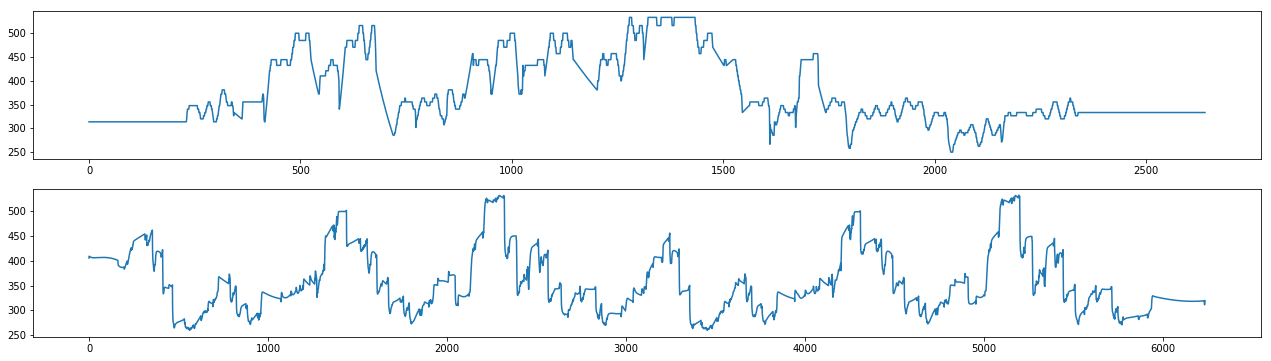

In [269]:
plt.figure(figsize=(22, 3*2))
plt.subplot(2, 1, 1)
plt.plot(orig_f0)
plt.subplot(2, 1, 2)
plt.plot(f0)

In [270]:
def ln2f(array):
    return np.exp(array)

In [271]:
np.set_printoptions(threshold=np.nan)
orig_lf0.shape
for i in range(2640):
    print(str(orig_f0[i]), str(i))

[313.72507] 0
[313.72507] 1
[313.72507] 2
[313.72507] 3
[313.72507] 4
[313.72507] 5
[313.72507] 6
[313.72507] 7
[313.72507] 8
[313.72507] 9
[313.72507] 10
[313.72507] 11
[313.72507] 12
[313.72507] 13
[313.72507] 14
[313.72507] 15
[313.72507] 16
[313.72507] 17
[313.72507] 18
[313.72507] 19
[313.72507] 20
[313.72507] 21
[313.72507] 22
[313.72507] 23
[313.72507] 24
[313.72507] 25
[313.72507] 26
[313.72507] 27
[313.72507] 28
[313.72507] 29
[313.72507] 30
[313.72507] 31
[313.72507] 32
[313.72507] 33
[313.72507] 34
[313.72507] 35
[313.72507] 36
[313.72507] 37
[313.72507] 38
[313.72507] 39
[313.72507] 40
[313.72507] 41
[313.72507] 42
[313.72507] 43
[313.72507] 44
[313.72507] 45
[313.72507] 46
[313.72507] 47
[313.72507] 48
[313.72507] 49
[313.72507] 50
[313.72507] 51
[313.72507] 52
[313.72507] 53
[313.72507] 54
[313.72507] 55
[313.72507] 56
[313.72507] 57
[313.72507] 58
[313.72507] 59
[313.72507] 60
[313.72507] 61
[313.72507] 62
[313.72507] 63
[313.72507] 64
[313.72507] 65
[313.72507] 66
[313.

[457.14297] 1269
[470.58807] 1270
[484.84802] 1271
[484.84802] 1272
[500.00006] 1273
[500.00006] 1274
[516.1291] 1275
[516.1291] 1276
[516.1291] 1277
[533.3331] 1278
[533.3331] 1279
[533.3331] 1280
[533.3331] 1281
[533.3331] 1282
[533.3331] 1283
[516.1291] 1284
[516.1291] 1285
[516.1291] 1286
[516.1291] 1287
[500.00006] 1288
[500.00006] 1289
[500.00006] 1290
[484.84802] 1291
[484.84802] 1292
[484.84802] 1293
[484.84802] 1294
[500.00006] 1295
[500.00006] 1296
[500.00006] 1297
[500.00006] 1298
[500.00006] 1299
[500.00006] 1300
[500.00006] 1301
[516.1291] 1302
[516.1291] 1303
[516.1291] 1304
[516.1291] 1305
[516.1291] 1306
[516.1291] 1307
[516.1291] 1308
[500.00006] 1309
[500.00006] 1310
[484.84802] 1311
[444.44406] 1312
[452.82953] 1313
[461.3732] 1314
[470.07806] 1315
[478.94742] 1316
[487.98386] 1317
[497.19083] 1318
[506.57147] 1319
[516.1291] 1320
[516.1291] 1321
[533.3331] 1322
[533.3331] 1323
[533.3331] 1324
[533.3331] 1325
[533.3331] 1326
[533.3331] 1327
[533.3331] 1328
[533.3331]

[320.] 2265
[320.] 2266
[320.] 2267
[320.] 2268
[320.] 2269
[326.53107] 2270
[326.53107] 2271
[326.53107] 2272
[333.33304] 2273
[333.33304] 2274
[340.42603] 2275
[340.42603] 2276
[340.42603] 2277
[347.82596] 2278
[347.82596] 2279
[355.5561] 2280
[355.5561] 2281
[355.5561] 2282
[355.5561] 2283
[355.5561] 2284
[355.5561] 2285
[355.5561] 2286
[355.5561] 2287
[355.5561] 2288
[355.5561] 2289
[347.82596] 2290
[347.82596] 2291
[340.42603] 2292
[340.42603] 2293
[333.33304] 2294
[333.33304] 2295
[326.53107] 2296
[326.53107] 2297
[320.] 2298
[320.] 2299
[320.] 2300
[320.] 2301
[320.] 2302
[320.] 2303
[320.] 2304
[320.] 2305
[320.] 2306
[326.53107] 2307
[326.53107] 2308
[326.53107] 2309
[333.33304] 2310
[333.33304] 2311
[340.42603] 2312
[340.42603] 2313
[347.82596] 2314
[347.82596] 2315
[355.5561] 2316
[355.5561] 2317
[355.5561] 2318
[355.5561] 2319
[363.63602] 2320
[363.63602] 2321
[355.5561] 2322
[355.5561] 2323
[355.5561] 2324
[355.5561] 2325
[355.5561] 2326
[347.82596] 2327
[347.82596] 2328
[

In [272]:
mgc, n1 = io_funcs.load_binary_file_frame(os.path.join(test_dir, 'nitech_jp_song070_f001_003.mgc'), 60)
bap, n2 = io_funcs.load_binary_file_frame(os.path.join(test_dir, 'nitech_jp_song070_f001_003.bap'), 1)
print(n1, n2)
print(mgc.shape)

6240 6240
(6240, 60)


In [273]:
print(num_frame)
mgc = mgc[:num_frame, :]
bap = bap[:num_frame, :]
io_funcs.array_to_binary_file(mgc, os.path.join(test_dir, 'nitech_jp_song070_f001_003.mgc'))
io_funcs.array_to_binary_file(bap, os.path.join(test_dir, 'nitech_jp_song070_f001_003.bap'))

6235


In [274]:
def run_process(args,log=True):
    logger = logging.getLogger("subprocess")

    # a convenience function instead of calling subprocess directly
    # this is so that we can do some logging and catch exceptions

    # we don't always want debug logging, even when logging level is DEBUG
    # especially if calling a lot of external functions
    # so we can disable it by force, where necessary
    if log:
        logger.debug('%s' % args)

    try:
        # the following is only available in later versions of Python
        # rval = subprocess.check_output(args)

        # bufsize=-1 enables buffering and may improve performance compared to the unbuffered case
        p = subprocess.Popen(args, bufsize=-1, shell=True,
                        stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                        close_fds=True, env=os.environ)
        # better to use communicate() than read() and write() - this avoids deadlocks
        (stdoutdata, stderrdata) = p.communicate()

        if p.returncode != 0:
            # for critical things, we always log, even if log==False
            logger.critical('exit status %d' % p.returncode )
            logger.critical(' for command: %s' % args )
            logger.critical('      stderr: %s' % stderrdata )
            logger.critical('      stdout: %s' % stdoutdata )
            raise OSError

        return (stdoutdata, stderrdata)

    except subprocess.CalledProcessError as e:
        # not sure under what circumstances this exception would be raised in Python 2.6
        logger.critical('exit status %d' % e.returncode )
        logger.critical(' for command: %s' % args )
        # not sure if there is an 'output' attribute under 2.6 ? still need to test this...
        logger.critical('  output: %s' % e.output )
        raise

    except ValueError:
        logger.critical('ValueError for %s' % args )
        raise

    except OSError:
        logger.critical('OSError for %s' % args )
        raise

    except KeyboardInterrupt:
        logger.critical('KeyboardInterrupt during %s' % args )
        try:
            # try to kill the subprocess, if it exists
            p.kill()
        except UnboundLocalError:
            # this means that p was undefined at the moment of the keyboard interrupt
            # (and we do nothing)
            pass

        raise KeyboardInterrupt

def wavgen_straight_type_vocoder(gen_dir, file_id_list, logger):
    '''
    Waveform generation with STRAIGHT or WORLD vocoders.
    (whose acoustic parameters are: mgc, bap, and lf0)
    '''

    pf_coef = 1.4
    fw_coef = 0.58
    co_coef = 511
    fl_coef = 1024
    mgc_dim = 60
    fw_alpha = 0.58
    sr = 16000
    fl = 1024



    counter=1
    max_counter = len(file_id_list)


    for filename in file_id_list:

        logger.info('creating waveform for %4d of %4d: %s' % (counter,max_counter,filename) )
        counter=counter+1
        base   = filename
        files = {'sp'  : base + '.sp',
                 'mgc' : base + '.mgc',
                 'f0'  : base + '.f0',
                 'lf0' : base + '.lf0',
                 'ap'  : base + '.ap',
                 'bap' : base + '.bap',
                 'wav' : base + '.wav'}

        mgc_file_name = files['mgc']
        bap_file_name = files['bap']

        cur_dir = os.getcwd()
        os.chdir(gen_dir)


        mgc_file_name = files['mgc']+'_p_mgc'
        post_filter(files['mgc'], mgc_file_name, mgc_dim, pf_coef, fw_coef, co_coef, fl_coef, gen_dir, SPTK)





        run_process('{sopr} -magic -1.0E+10 -EXP -MAGIC 0.0 {lf0} | {x2x} +fd > {f0}'.format(sopr=SPTK['SOPR'], lf0=files['lf0'], x2x=SPTK['X2X'], f0=files['f0']))

        run_process('{sopr} -c 0 {bap} | {x2x} +fd > {ap}'.format(sopr=SPTK['SOPR'],bap=files['bap'],x2x=SPTK['X2X'],ap=files['ap']))


        run_process('{mgc2sp} -a {alpha} -g 0 -m {order} -l {fl} -o 2 {mgc} | {sopr} -d 32768.0 -P | {x2x} +fd > {sp}'
                        .format(mgc2sp=SPTK['MGC2SP'], alpha=fw_alpha, order=mgc_dim-1, fl=fl, mgc=mgc_file_name, sopr=SPTK['SOPR'], x2x=SPTK['X2X'], sp=files['sp']))

        run_process('{synworld} {fl} {sr} {f0} {sp} {ap} {wav}'
                         .format(synworld=WORLD['SYNTHESIS'], fl=fl, sr=sr, f0=files['f0'], sp=files['sp'], ap=files['ap'], wav=files['wav']))

#         run_process('rm -f {ap} {sp} {f0}'.format(ap=files['ap'],sp=files['sp'],f0=files['f0']))

        os.chdir(cur_dir)

def post_filter(mgc_file_in, mgc_file_out, mgc_dim, pf_coef, fw_coef, co_coef, fl_coef, gen_dir, SPTK):


    line = "echo 1 1 "
    for i in range(2, mgc_dim):
        line = line + str(pf_coef) + " "

    run_process('{line} | {x2x} +af > {weight}'
                .format(line=line, x2x=SPTK['X2X'], weight=os.path.join(gen_dir, 'weight')))

    run_process('{freqt} -m {order} -a {fw} -M {co} -A 0 < {mgc} | {c2acr} -m {co} -M 0 -l {fl} > {base_r0}'
                .format(freqt=SPTK['FREQT'], order=mgc_dim-1, fw=fw_coef, co=co_coef, mgc=mgc_file_in, c2acr=SPTK['C2ACR'], fl=fl_coef, base_r0=mgc_file_in+'_r0'))

    run_process('{vopr} -m -n {order} < {mgc} {weight} | {freqt} -m {order} -a {fw} -M {co} -A 0 | {c2acr} -m {co} -M 0 -l {fl} > {base_p_r0}'
                .format(vopr=SPTK['VOPR'], order=mgc_dim-1, mgc=mgc_file_in, weight=os.path.join(gen_dir, 'weight'),
                        freqt=SPTK['FREQT'], fw=fw_coef, co=co_coef,
                        c2acr=SPTK['C2ACR'], fl=fl_coef, base_p_r0=mgc_file_in+'_p_r0'))

    run_process('{vopr} -m -n {order} < {mgc} {weight} | {mc2b} -m {order} -a {fw} | {bcp} -n {order} -s 0 -e 0 > {base_b0}'
                .format(vopr=SPTK['VOPR'], order=mgc_dim-1, mgc=mgc_file_in, weight=os.path.join(gen_dir, 'weight'),
                        mc2b=SPTK['MC2B'], fw=fw_coef,
                        bcp=SPTK['BCP'], base_b0=mgc_file_in+'_b0'))

    run_process('{vopr} -d < {base_r0} {base_p_r0} | {sopr} -LN -d 2 | {vopr} -a {base_b0} > {base_p_b0}'
                .format(vopr=SPTK['VOPR'], base_r0=mgc_file_in+'_r0', base_p_r0=mgc_file_in+'_p_r0',
                        sopr=SPTK['SOPR'],
                        base_b0=mgc_file_in+'_b0', base_p_b0=mgc_file_in+'_p_b0'))

    run_process('{vopr} -m -n {order} < {mgc} {weight} | {mc2b} -m {order} -a {fw} | {bcp} -n {order} -s 1 -e {order} | {merge} -n {order2} -s 0 -N 0 {base_p_b0} | {b2mc} -m {order} -a {fw} > {base_p_mgc}'
                .format(vopr=SPTK['VOPR'], order=mgc_dim-1, mgc=mgc_file_in, weight=os.path.join(gen_dir, 'weight'),
                        mc2b=SPTK['MC2B'],  fw=fw_coef,
                        bcp=SPTK['BCP'],
                        merge=SPTK['MERGE'], order2=mgc_dim-2, base_p_b0=mgc_file_in+'_p_b0',
                        b2mc=SPTK['B2MC'], base_p_mgc=mgc_file_out))

    return

In [276]:
import logging
logger = logging.getLogger("wav_generation")
synth_id_list = ['nitech_jp_song070_f001_003']
wavgen_straight_type_vocoder(test_dir, synth_id_list, logger)

In [259]:
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [260]:
a = torch.rand(2, 6)
b = torch.rand(1, 6)
c = torch.rand(4, 6)
packed = pad_sequence([a, b, c], batch_first=True)
print(packed)

tensor([[[0.4613, 0.8188, 0.8283, 0.1828, 0.8686, 0.7335],
         [0.3153, 0.4535, 0.3611, 0.3983, 0.6700, 0.9922],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.2323, 0.8332, 0.0272, 0.9470, 0.9125, 0.1098],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.9239, 0.3953, 0.2098, 0.6734, 0.3203, 0.4412],
         [0.0144, 0.6785, 0.7117, 0.1178, 0.3742, 0.4244],
         [0.1442, 0.2104, 0.2850, 0.1576, 0.3056, 0.1083],
         [0.8345, 0.0663, 0.4776, 0.5388, 0.0871, 0.3274]]])


In [155]:
def collate_rnn(batch):
    lengths = [i[0].size(0) for i in batch]
    labs = [i[0] for i in batch]
    cmps = [i[1] for i in batch]
#     print(labs[2].size())
#     print(cmps[2].size())
#     print(lengths)


    return labs, cmps, lengths

In [277]:
# TODO to implement cross-validation, print something here to see whether could do normalisation in Pytorch
batch_size = 27
# train_set = NITDataset(no_silence_norm_lab_file_list[:27], no_silence_norm_cmp_file_list[:27])
# train_loader = data.DataLoader(train_set, shuffle=True, batch_size=27, collate_fn=collate_rnn)

train_set = NITDataset(no_silence_norm_lab_file_list[0] * 27, no_silence_norm_cmp_file_list[0] * 27)
train_loader = data.DataLoader(train_set, shuffle=True, batch_size=27, collate_fn=collate_rnn)

valid_set = NITDataset(no_silence_norm_lab_file_list[-2:], no_silence_norm_cmp_file_list[-2:])
valid_loader = data.DataLoader(valid_set, shuffle=True, batch_size=2, collate_fn=collate_rnn)

tmp = next(iter(train_loader))

AssertionError: 

In [236]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim, lab_dim, cmp_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        
#         self.fc = nn.Linear(lab_dim, 30)
        self.lstm = nn.LSTM(142, hidden_dim, batch_first=True)
        self.hidden2cmp = nn.Linear(hidden_dim, cmp_dim)
        self.hidden = self.init_hidden(27)
        
    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_dim), 
                (torch.zeros(1, batch_size, self.hidden_dim)))
        
    def forward(self, dur_lab, lengths):
        lengths, perm_ind = torch.IntTensor(lengths).sort(0, descending=True)
        
        perm_ind_list = perm_ind.tolist()
        dur_lab = [dur_lab[i] for i in perm_ind_list]
#         dur_lab = dur_lab[perm_ind]
        
#         packed = pack_sequence(dur_lab)
        
        padded = pad_sequence(dur_lab, batch_first=True)
        packed = pack_padded_sequence(padded, list(lengths.data), batch_first=True)

        
        packed_output, self.hidden = self.lstm(packed, self.hidden)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        _, unperm_ind = perm_ind.sort(0)
        output = output[unperm_ind]
        
        res = self.hidden2cmp(output)
        
        return res

In [214]:
def train2(model, train_loader, valid_loader, epoch):
    model.train()
    for batch_ind, batch in enumerate(train_loader):
        lab, cmp, lengths = batch[0], batch[1], batch[2]
        batch_size = len(batch[0])
        cmp = pad_sequence(cmp, batch_first=True)
        model.hidden = model.init_hidden(batch_size)
        predict = model(lab, lengths)
        loss = criterion(predict, cmp)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_ind % log_interval == 0:
            val_loss = evaluate2(model, valid_loader)
            train_loss = loss.item()
            epoch_progress = 100. * batch_ind / len(train_loader)
            print('Train Epoch: {}({:.0f}%)\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(
                epoch, epoch_progress, train_loss, val_loss))
            
def evaluate2(model, valid_loader):
    model.eval()
    total_loss = 0
    n_examples = 0
    for batch_ind, batch in enumerate(valid_loader):
#         lab, cmp, sample_len = Variable(batch[0], volatile=True), Variable(batch[1]), batch[2]
        
        lab, cmp, lengths = batch[0], batch[1], batch[2]
        batch_size = len(batch[0])
        cmp = pad_sequence(cmp, batch_first=True)
        model.hidden = model.init_hidden(batch_size)
        predict = model(lab, lengths)
        loss = criterion(predict, cmp)
        
#         loss = criterion(output, cmp, size_average=False).item()
#         total_loss += loss
#         n = len(lab)

#         n_examples += n
    
#     total_loss /= (n_examples * sample_len * cmp.size()[-1])
    return loss   

In [278]:
pitch_model = LSTMModel(hidden_dim=5, lab_dim=142, cmp_dim=1)

lr = 0.01
log_interval = 1
epochs = 60
# optimizer = torch.optim.SGD(one_layer_model.parameters(), lr=lr)
optimizer = torch.optim.Adam(pitch_model.parameters(), lr=lr)
criterion = F.mse_loss
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.05)
# criterion = nn.MSELoss()
for epoch in range(1, epochs+1):
    train2(pitch_model, train_loader, valid_loader, epoch)

Train Epoch: 1(0%)	Train Loss: 0.457840	Val Loss: 0.358703
Train Epoch: 2(0%)	Train Loss: 0.423742	Val Loss: 0.322012
Train Epoch: 3(0%)	Train Loss: 0.389204	Val Loss: 0.286780
Train Epoch: 4(0%)	Train Loss: 0.355454	Val Loss: 0.263115
Train Epoch: 5(0%)	Train Loss: 0.323997	Val Loss: 0.250599
Train Epoch: 6(0%)	Train Loss: 0.296184	Val Loss: 0.240044
Train Epoch: 7(0%)	Train Loss: 0.276968	Val Loss: 0.220463
Train Epoch: 8(0%)	Train Loss: 0.260750	Val Loss: 0.211402
Train Epoch: 9(0%)	Train Loss: 0.253685	Val Loss: 0.201418
Train Epoch: 10(0%)	Train Loss: 0.239650	Val Loss: 0.181811
Train Epoch: 11(0%)	Train Loss: 0.224915	Val Loss: 0.173754
Train Epoch: 12(0%)	Train Loss: 0.212903	Val Loss: 0.169293
Train Epoch: 13(0%)	Train Loss: 0.202421	Val Loss: 0.170180
Train Epoch: 14(0%)	Train Loss: 0.194231	Val Loss: 0.170614
Train Epoch: 15(0%)	Train Loss: 0.187350	Val Loss: 0.170986
Train Epoch: 16(0%)	Train Loss: 0.179336	Val Loss: 0.175933
Train Epoch: 17(0%)	Train Loss: 0.173630	Val Loss